# Kostensuche

## Routenplanung
- Endlich ein realistisches Problem! Heutzutage ist Routenplanung in jedem Auto und auf jedem Smartphone selbstverständlich.
- Wir verwenden absichtlich ein (für die meisten) *wenig vertrautes* Land. So können wir uns nicht auf unsere Intutition verlassen - und genau geht es dem Computer!
- Diese Idee stammt aus *Russell/Norvig: Künstliche Intelligenz - ein moderner Ansatz*

In [3]:
staedte_rumaenien = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

strassen_rumaenien = dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142))

def ergaenze_rueckwege(strassen):
    neu = [(ziel, start, laenge)
           for start in strassen
           for ziel, laenge in strassen[start].items()]
    for stadt, ziel, laenge in neu:
        von_stadt = strassen.setdefault(stadt, {})
        von_stadt[ziel] = laenge

ergaenze_rueckwege(strassen_rumaenien)

In [4]:
# Für die graphische Darstellung verwenden wir die beiden folgenden Bibliotheken. Bitte in Anaconda Navigator installieren (oder per conda, pip, etc.)
import matplotlib.pyplot as plt
import networkx as nx

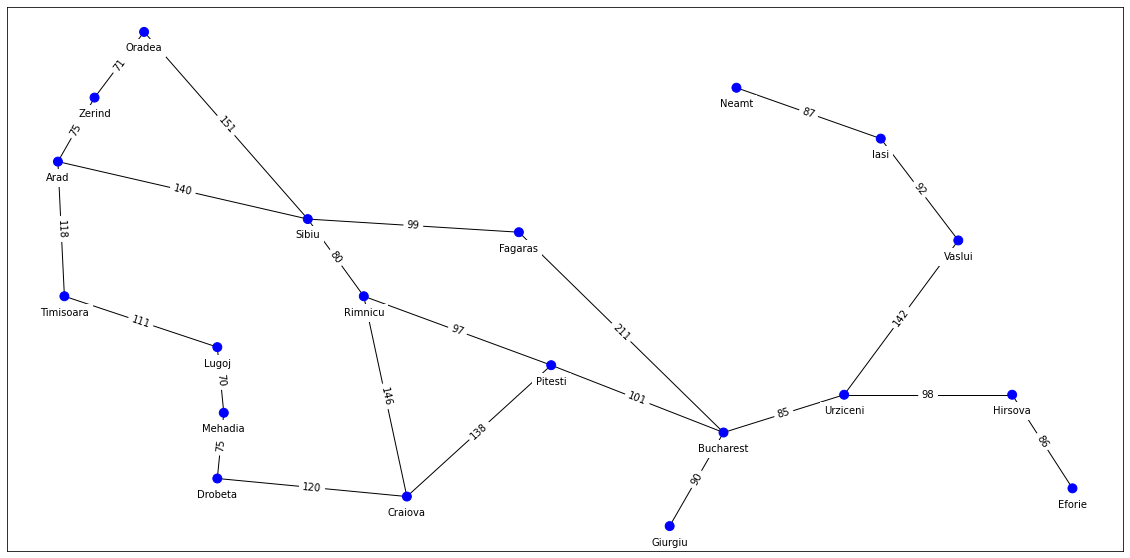

In [5]:
def zeichne_karte(staedte, alle_strassen, farben={}, styles="solid"):
    """Zeichne eine Landkarte."""
    plt.figure(figsize=(20, 10)) 

    G = nx.Graph()
    # Städte = Knoten
    for stadt, coords in staedte.items():
        G.add_node(stadt, position=coords, color=farben.get(stadt, "blue"))
    # Strassen = Kanten
    for start, strassen in alle_strassen.items():
        for ziel, laenge in strassen.items():
            G.add_edge(start, ziel, laenge=laenge, color=farben.get((start, ziel), "black"))

    positionen = nx.get_node_attributes(G,'position')
    knoten_label_pos = {stadt:(x,y-10) for (stadt, (x,y)) in positionen.items()}
    node_label_handles = nx.draw_networkx_labels(G, pos=knoten_label_pos, font_size=10)
    for label in node_label_handles.values():
        label.set_bbox(dict(facecolor='white', edgecolor='none'))

    kanten_gewichte = nx.get_edge_attributes(G,'laenge')
    farben_knoten = nx.get_node_attributes(G, "color").values()
    farben_kanten = nx.get_edge_attributes(G, "color").values()

    nx.draw_networkx_nodes(G, pos=positionen, node_size=80, node_color=farben_knoten)
    nx.draw_networkx_edges(G, pos=positionen, style=styles, edge_color=farben_kanten)
    for kante in G.edges():    
        # muss leider einzeln gemacht werden, weil man sonst keine unterschiedlichen Farben für die Labels setzen kann
        wert = kanten_gewichte[kante]
        farbe = farben.get(kante, "black")
        nx.draw_networkx_edge_labels(G, pos=positionen, edge_labels={kante:wert}, font_color=farbe, font_size=10)

    plt.show()

zeichne_karte(staedte_rumaenien, strassen_rumaenien)

## Suchprobleme mit Aktionskosten

In [6]:
class Suchproblem:
    """Abstrakte Klasse für allgemeine Suchprobleme.
    Konkrete Problemklassen werden von dieser Klasse abgeleitet und überschreiben
    die Methoden moegliche_aktionen() und fuehre_aktion_aus(), evtl. auch
    ist_zielzustand(). """

    def __init__(self, startzustand, zielzustand=None):
        """erzeugt ein neues Suchproblem mit festem Startzustand.
        Falls kein Zielzustand vorgegeben wird, muss die Methode
        ist_zielzustand() überschrieben werden."""
        self.startzustand = startzustand
        self.zielzustand = zielzustand

    def moegliche_aktionen(self, zustand):
        """liefert alle in zustand möglichen Aktionen zurück."""
        pass

    def fuehre_aktion_aus(self, zustand, aktion):
        """wendet aktion in zustand an und gibt den daraus resultierenden
        neuen Zustand zurück. """
        pass

    def aktionskosten(self, zustand, aktion, zustand_neu=None):
        """NEU: bestimmt die Kosten für die Ausführung von aktion in zustand,
        wenn aktion in zustand_neu geführt hat."""
        pass

    def ist_zielzustand(self, zustand):
        """prüft, ob der übergebene Zustand die Zielbedingung erfüllt.
        Standardverhalten: Es gibt genau einen Zielzustand self.ziel_zustand,
        mit dem zustand verglichen wird.
        Unterklassen von Suchproblem können diese Methode überschreiben und so
        andere Zieltests implementieren. """
        return zustand == self.zielzustand

In [7]:
class Knoten:
    """Ein Knoten in einem Suchbaum. Der Knoten speichert Referenzen auf
    den gespeicherten Zustand sowie den Vorgängerknoten und die Aktion, aus denen
    dieser Zustand entstanden ist."""

    naechste_nummer = 0  

    def __init__(self, zustand, vorgaenger=None, aktion=None, pfadkosten=0):
        """erzeugt einen neuen Suchknoten und setzt dabei Referenzen auf
        Vorgängerknoten und die gerade ausgeführte Aktion.
        Um später nachvollziehen zu können, in welcher Reihenfolge die Knoten erzeugt wurden,
        werden sie aufsteigend durchnummeriert."""
        self.zustand = zustand
        self.vorgaenger = vorgaenger
        self.aktion = aktion
        self.tiefe = vorgaenger.tiefe + 1 if vorgaenger else 0
        self.pfadkosten = pfadkosten   # NEU: speichert die Kosten, die auf dem Pfad zu diesem Knoten angefallen sind
        self.nummer = Knoten.naechste_nummer
        Knoten.naechste_nummer += 1

    def pfad_hierher(self):
        """verfolgt den Pfad von hier rückwärts bis zum Wurzelknoten und liefert die Liste
        der Aktionen zurück, die in den jetzigen Zustand geführt haben."""
        pfad = []
        knoten = self  
        while knoten.vorgaenger: 
            pfad.append(knoten.aktion)
            knoten = knoten.vorgaenger  
        pfad.reverse()
        return pfad

    def folgeknoten(self, problem, aktion):
        """wendet eine Aktion im aktuellen Zustand an und verpackt den resultierenden
        Zustand in einen neuen Knoten mit korrekt gesetztem Vorgänger usw."""
        zustand_neu = problem.fuehre_aktion_aus(self.zustand, aktion)
        # NEU: Erhöhe die Pfadkosten um die Kosten der aktuellen Aktion:
        pfadkosten_neu = self.pfadkosten + problem.aktionskosten(self.zustand, aktion, zustand_neu)
        knoten_neu = Knoten(zustand_neu, vorgaenger=self, aktion=aktion, pfadkosten=pfadkosten_neu)
        return knoten_neu

    def expandiere(self, problem):
        """liefert alle von diesem Knoten direkt erreichbaren Folgeknoten"""
        return [self.folgeknoten(problem, aktion)
                for aktion in problem.moegliche_aktionen(self.zustand)]
    
    def __lt__(self, anderer):
        return self.nummer < anderer.nummer

Die Klasse *Suchproblem* beschreibt, wie man aus einer Problemstellung einen impliziten *Graphen* aufbaut, den man dann durchsucht.  Das wir Landkarten sowieso schon *explizit* als Graphen repräsentieren, muss gar nicht viel "umgebaut" werden, um die Landkarte als *Suchproblem* zu beschreiben:

In [8]:
class Routenplanung(Suchproblem):
    def __init__(self, start, ziel, staedte=staedte_rumaenien, strassen=strassen_rumaenien):
        super().__init__(start, ziel)
        self.staedte = staedte
        self.strassen = strassen

    def moegliche_aktionen(self, zustand):
        stadt = zustand   # Zustand ist einfach die Stadt, in der wir gerade sind
        return self.strassen[stadt].keys()  # Ziele sind die von stadt erreichbaren Städte

    def fuehre_aktion_aus(self, zustand, aktion):
        ziel = aktion  # Wieder ganz einfach: eine Aktion wird repräsentiert durch die Zielstadt
        return ziel

    def aktionskosten(self, zustand, aktion, zustand_neu=None):
        stadt = zustand
        ziel = aktion
        return self.strassen[stadt][ziel]  # Kosten für Kante stadt->ziel

    def koordinaten(self, stadt):
        return self.staedte[stadt]

Eigentlich müssten wir den Breitensuche-Algorithmus nun für die Routenplanung verwenden können. Probieren wir es doch einfach einmal aus..

In [9]:
navi = Routenplanung("Sibiu", "Bucharest")
import breitensuche
loesung = breitensuche.breitensuche(navi)
loesung

['Fagaras', 'Bucharest']

Prima - das klappt ja scheinbar bestens: Wir fahren von Sibiu über Fagaras nach Bucharest. 

Aber... schau dir die Karte noch einmal genau an. Was fällt auf?

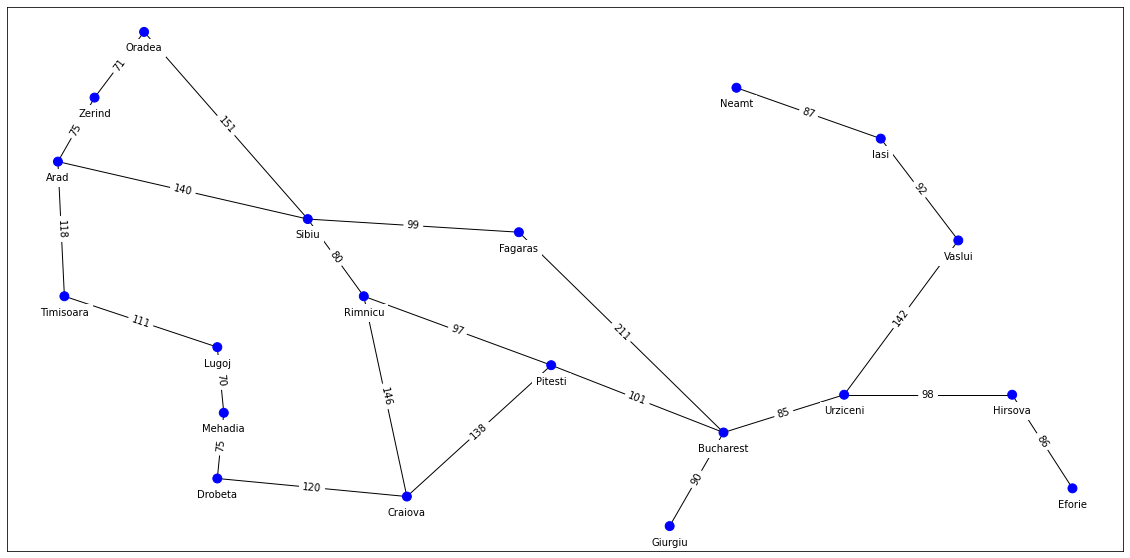

In [10]:
zeichne_karte(staedte_rumaenien, strassen_rumaenien)

#### Antwort: ####
Die Route von Sibiu über Fagaras nach Bucharest hat die Länge [*Anwort einsetzen*].  

Allerdings könnte man [*...vervollständige diesen Satz* ]

## Berücksichtigung von Pfadkosten im Suchalgorithmus

Bei der Breitensuche war die "Grenze", also die Liste der als nächstes zu untersuchenenden Knoten, immer so sortiert, dass die Suchknoten mit der *kleinsten Tiefe* am Anfang standen, d.h. diejenigen Knoten, die in möglichst wenigen Aktionen vom Startzustand aus erreichbar waren. Diese Knoten wurden also zuerst untersucht und damit war garantiert, dass das Ziel in möglichst *wenigen Schritten* gefunden wurde.  Im Programm wurde das durch die Verwendung einer *Warteschlange (engl. Queue)* realisiert (bzw. einer Liste, aus der immer am *Anfang* Elemente entfernt wurden).

Diesen Algorithmus wandeln wir nun so ab, dass immer die Knoten mit den *kleinsten Pfadkosten* zuerst untersucht werden, d.h. diejenigen, bei denen die *Summe der Aktionskosten* am kleinsten ist. Wenn wir die Knoten in dieser Reihenfolge untersuchen, ist garantiert, dass wir das Ziel auf dem Pfad mit *minimalen Kosten* erreichen.

Allerdings reicht es dazu nicht mehr, neu expandierte Knoten einfach vorne in die "Grenze" einzufügen wie bei der Breitensuche. Auch sie am Ende einzufügen ist nicht richtig, denn evtl. wird im Lauf der Suche ja der eine oder andere "Schleichweg" zu einem (Zwischen-)Ziel entdeckt. Stattdessen müssen wir dafür sorgen, dass in der "Grenze" immer der aktuell vielversprechendste Knoten vorne steht, d.h. der zu dem der kürzeste bekannte Pfad führt.

Dies erreichen wir, indem wir die "Grenze" als *Prioritätswarteschlange (engl. priority queue)* implementieren. Es gibt in der Informatik mehrere effiziente Varianten eine Priority Queue zu implementieren, z.B. mithilfe der Datenstruktur *heap*. Wir verwenden hier die intuitive, aber ineffizientere Variante mithilfe einer *sortiert gehaltenen Liste*.

In [11]:
import bisect

class PriorityQueue:
    """Eine extrem einfach Implementierung des Datentyps *Prioritätswarteschlange*:
    Elemente werden so eingefügt, dass sie später in der Reihenfolge ihrer Priorität
    (bestimmt durch die Bewertungsfunktion) ausgelesen werden.
    Hier: Je *kleiner* die Priorität, desto früher wird ein Element wieder ausgelesen.
    (Priorität entspricht also "Kosten": Je niedriger die Kosten, desto besser, also frühere Verarbeitung.)
    Verwendet als Datenstruktur keinen Heap o.ä., sondern eine normale Liste. Ein neues Element wird mit
    der Funktion bisect.insort() eingefügt, die binäre Suche verwendet, um die richtige Einfügeposition
    zu finden. Das ist für unsere Zwecke ausreichend schnell.
    Alternativ könnte man das Modul heapq aus der Standardbibliothek verwenden.
    """

    def __init__(self, bewertungsfunktion):
        """erzeugt eine neue PQ. Eingefügte Elemente anhand des mit bewertungsfunktion() 
        berechneten Werts in die PQ einsortiert."""
        self.liste = []  # In der Theorie wäre eine verkettete Liste (zB deque) besser - praktisch nur bei sehr großen Datenmengen
        self.bewertungsfunktion = bewertungsfunktion

    def __str__(self):
        return str([(prio, wert) for prio, wert in self.liste])

    def fuege_ein(self, element):
        prioritaet = self.bewertungsfunktion(element)
        bisect.insort(self.liste, (prioritaet, element))  # fügt element so ein, dass liste aufsteigend sortiert bleibt

    def entferne_kleinstes(self):
        """entfernt das kleinste Element"""
        prioritaet, element = self.liste.pop(0)
        return element, prioritaet

    def __iter__(self):
        """ermöglicht das Iterierten über diese priority queue mit 'for .. in ...:'"""
        return iter(self.liste)

In [12]:
# Beispiel für die Verwendung der PriorityQueue. Die eingefügten Elemente werden anhand des von len() berechneten Werts priorisiert
# d.h. Werte (z.B. Strings) mit kleiner Länge stehen vorne in der PriorityQueue
satz = "Kurze Wörter bekommen in diesem Satz erstaunlicherweise die höchste Priorität"
print("Der folgende Satz wird nun Wort für Wort in die PQ eingefügt:")
print(f"'{satz}'")

pq = PriorityQueue(bewertungsfunktion=len)  # Prioritäten werden mit der Funktion len() berechnet

woerter = satz.split()
for wort in woerter:
    pq.fuege_ein(wort)

for prio, wort in pq:
    print(prio, wort)

Der folgende Satz wird nun Wort für Wort in die PQ eingefügt:
'Kurze Wörter bekommen in diesem Satz erstaunlicherweise die höchste Priorität'
2 in
3 die
4 Satz
5 Kurze
6 Wörter
6 diesem
7 höchste
8 bekommen
9 Priorität
18 erstaunlicherweise


## Bestensuche


Die **Bestensuche** ist eine Verallgemeinerung der Breitensuche. Neue Knoten werden nicht mehr automatisch am Ende der "Grenze" eingefügt, sondern zuerst *bewertet*. Der Algorithmus fügt die Knoten dann gemäß ihrer Bewertung weiter vorne (bei niedriger, d.h. "guter" Bewertung) oder weiter hinten (bei höherer, also "schlechterer" Bewertung) in die Priority Queue in.  Dadurch wird sichergestellt, dass immer der aktuell am besten bewertete Knoten zuerst weiter untersucht wird.

In [13]:
def bestensuche(problem, bewertungsfunktion):
    """sucht nach der Lösung von problem, die optimal ist im Sinn der bewertungsfunktion()"""
    untersucht = {}  # NEU: dict statt set, damit wir nicht nur den Zustand, sondern auch den bisherigen Knoten speichern können
    grenze = PriorityQueue(bewertungsfunktion)  # NEU: PriorityQueue statt Liste
    grenze.fuege_ein(Knoten(problem.startzustand))
    while grenze:
        knoten, bewertung = grenze.entferne_kleinstes()
        untersucht[knoten.zustand] = knoten
        if problem.ist_zielzustand(knoten.zustand):
            return knoten.pfad_hierher()
        folge_knoten = knoten.expandiere(problem)
        for fk in folge_knoten:
            if fk.zustand in untersucht:
                pfadkosten_alt = untersucht[fk.zustand].pfadkosten
                if pfadkosten_alt <= fk.pfadkosten:
                    continue    # neuer Knoten wird ignoriert, weil auf einem kürzeren Weg bereits vorher erreicht
            grenze.fuege_ein(fk)
    return None

#### Breitensuche als Bestensuche
Wie genau die Bestensuche sich verhält, hängt von der verwendeten *Bewertungsfunktion* ab. Wir werden verschiedene Varianten kennenlernen.

Eine der einfachsten Bewertungsfunktionen entsteht, wenn man die Aktionskosten (wie bisher) ignoriert und nur die *Tiefe* eines Knotens im Suchbaum zur Bewertung heranzieht, d.h. die Anzahl der Aktionen, die man gebraucht hat, um diesen Zustand zu erreichen. Die Tiefe wird beim Anlegen eines neuen Knotens automatisch durch die folgende Zeile in der init-Methode bestimmt:  
`self.tiefe = vorgaenger.tiefe + 1 if vorgaenger else 0`



In [14]:
def breitensuche_als_bestensuche(problem):
    return bestensuche(problem, lambda knoten: knoten.tiefe)


# Zur Erklärung: Was ist ein Lambda-Ausdruck?
# Eine anonyme Funktion, d.h. ohne Namen, die "spontan" angelegt wird,
# um als Parameter an eine andere Funktion übergegeben zu werden
# In Python sind Lambda-Ausdrücke auf einen einzigen Ausdruck beschränkt,
# dessen Wert zurückgegeben wird (ein return-Statement ist nicht nötig)

# Alternative Definition von breitensuche_als_bestensuche ohne Lambda-Ausdruck:

# def bestimme_tiefe(knoten):
#     return knoten.tiefe

# def breitensuche_als_bestensuche(problem):
#     return bestensuche(problem, bestimme_tiefe)

In [15]:
navi = Routenplanung("Sibiu", "Bucharest")
loesung = breitensuche_als_bestensuche(navi)
loesung

['Fagaras', 'Bucharest']

## Uniforme Kostensuche

Statt der Tiefe eines Knotens im Suchbaum sollen nun die *Pfadkosten* des Knotens zur Bewertung herangezogen werden, d.h. die Summe aller Aktionskosten auf dem Weg bis zu diesem Knoten. 

Wir verwenden dazu wieder den Algorithmus *bestensuche*, nur bestimmt die Bewertungsfunktion diesmal die "Güte" eines Knotens anhand dessen Pfadkosten:

In [16]:
def uniforme_kostensuche(problem):
    return bestensuche(problem, lambda knoten: knoten.pfadkosten)


# Alternative ohne Lambda:
# def bewertung_uniforme_kostensuche(knoten):
#     return knoten.pfadkosten
# 
# def uniforme_kostensuche(problem):
#     return bestensuche(problem, bewertung_uniforme_kostensuche)

Wenn alles funktioniert, sollte jetzt die beste Route von Sibiu nach Bucharest *mehr* Zwischenstationen enthalten, dafür aber *geringere* Kosten verursachen:

In [17]:
navi = Routenplanung("Sibiu", "Bucharest")
loesung = uniforme_kostensuche(navi)
loesung

['Rimnicu', 'Pitesti', 'Bucharest']

Es klappt! Dies ist die optimale Route (gemäß der anfallenden Pfadkosten).

Ein weiteres Beispiel:

In [18]:
navi = Routenplanung("Sibiu", "Hirsova")
loesung = uniforme_kostensuche(navi)
loesung

['Rimnicu', 'Pitesti', 'Bucharest', 'Urziceni', 'Hirsova']

## Visualisierung der Bestensuche

In [19]:
def bestensuche_visualisierung(problem, bewertungsfunktion, stop=-1):
    untersucht = {} 
    grenze = PriorityQueue(bewertungsfunktion)
    grenze.fuege_ein(Knoten(problem.startzustand))
    knoten = None
    zaehler = 0
    while grenze:
        knoten, bewertung = grenze.entferne_kleinstes()
        if knoten.zustand in untersucht:
            pfadkosten_alt = untersucht[knoten.zustand].pfadkosten
            if pfadkosten_alt <= knoten.pfadkosten:
                continue    # neuer Knoten wird ignoriert, weil auf einem kürzeren Weg bereits vorher erreicht
        zaehler += 1
        untersucht[knoten.zustand] = knoten
        if problem.ist_zielzustand(knoten.zustand):
            farben = bestimme_farben_routenplanung(problem, untersucht, knoten, grenze)
            return knoten, farben, 1
        if zaehler == stop:
            farben = bestimme_farben_routenplanung(problem, untersucht, knoten, grenze)
            return knoten, farben, zaehler+1
        folge_knoten = knoten.expandiere(problem)
        for fk in folge_knoten:
            if fk.zustand in untersucht:
                pfadkosten_alt = untersucht[fk.zustand].pfadkosten
                if pfadkosten_alt <= fk.pfadkosten:
                    continue    # neuer Knoten wird ignoriert, weil auf einem kürzeren Weg bereits vorher erreicht
            grenze.fuege_ein(fk)
    else:
        farben = bestimme_farben_routenplanung(problem, untersucht, knoten, grenze)
        return knoten, farben, 1

def bestimme_farben_routenplanung(problem, untersucht, aktuell, grenze):
    f_untersucht, f_aktuell, f_grenze = "gray", "red", "orange"
    f_pfad, f_start = "green", "blue"
    start, ziel = problem.startzustand, problem.zielzustand
    farben = {zustand: "black" for zustand in problem.staedte}
    farben_kanten = {(s1, s2): "black" for s1 in problem.strassen for s2 in problem.moegliche_aktionen(s1)}
    farben.update(farben_kanten)
    
    for stadt in untersucht:
        farben[stadt] = f_untersucht
    for prio, stadt in grenze:
        farben[stadt.zustand] = f_grenze

    kante_start = problem.startzustand
    for kante_ende in aktuell.pfad_hierher():
        farben[(kante_start, kante_ende)] = f_pfad
        farben[(kante_ende, kante_start)] = f_pfad
        farben[kante_ende] = f_pfad
        kante_start = kante_ende

    farben[aktuell.zustand] = f_aktuell
    farben[problem.startzustand] = f_start
    return farben

In [20]:
# Dieser Zähler wird in der nächsten Zelle verwendet und dort automatisch
# geändert.  Wenn du wieder bei 1 starten willst, führe einfach
# diese Zelle hier noch einmal aus.
zaehler = 1

Schritt 1:
Stadt: Sibiu  Bewertung: 0


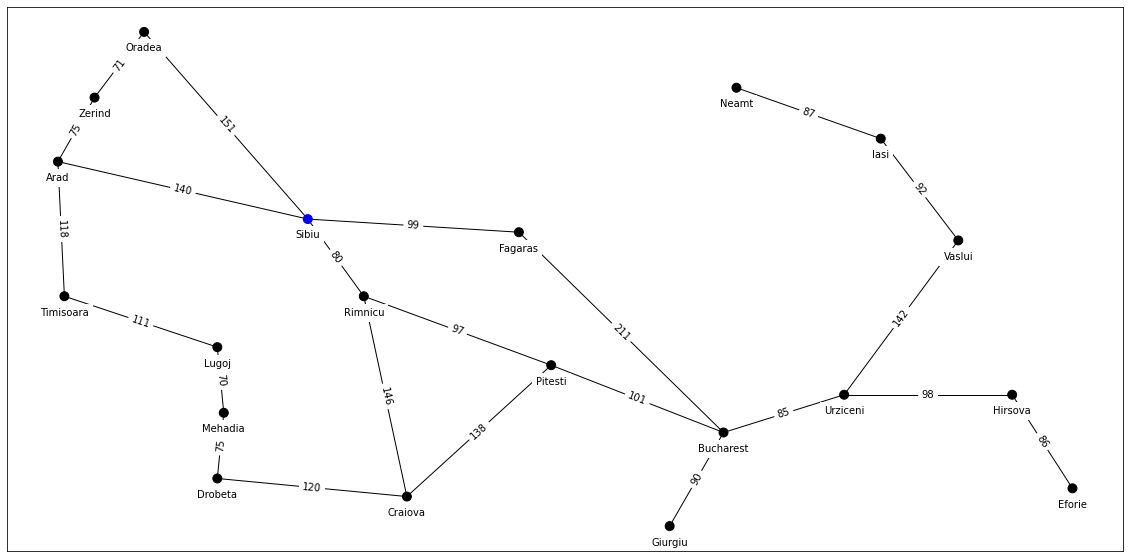

In [21]:
# Drücke wiederholt [Strg-Enter] um den Suchprozess schrittweise zu visualieren.
# Am Ende der Suchprozesses startet der Zähler automatisch wieder von vorne.
# Führe die vorherige Zelle aus, um die Suche zu unterbrechen und wieder von vorne zu starten.
navi = Routenplanung("Sibiu", "Hirsova")
kostenfunktion = lambda knoten: knoten.pfadkosten   # uniforme Kostensuche

print(f"Schritt {zaehler}:")
knoten_aktuell, farben, zaehler = bestensuche_visualisierung(navi, kostenfunktion, zaehler)
if knoten_aktuell:
    print(f"Stadt: {knoten_aktuell.zustand}  Bewertung: {kostenfunktion(knoten_aktuell)}")
zeichne_karte(navi.staedte, navi.strassen, farben=farben)

## Heuristiken
Wer von Freiburg nach Basel fahren will, wird wohl kaum versuchen, über Karlsruhe, Frankfurt und Hamburg dorthin zu gelangen.  Aber woher weiß der Mensch, dass eine Wegstrecke oder Zugfolge sinnlos ist, ohne sie genauer zu analysieren? 

Die Antwort der Psychologie und KI-Forschung ist, dass Menschen "Faustregeln" benutzen, wenn sie komplexe Entscheidungen treffen müssen und mögliche Lösungen bewerten und vergleichen.  Bei der Routenplanung ist eine solche Faustregel die *Luftliniendistanz*: Ich wähle diejenige Straße, die mich in Luftlinie meinem Ziel am nächsten bringt.  Die Luftlinie liefert also einen guten Anhaltspunkt dafür, ob ich mich in Richtung des Ziels bewege. 

In der KI spricht man statt von Faustregeln von **Heuristiken** (von griechisch *heurískein*: finden, entdecken). Verblüffenderweise werden sie nicht nur benutzt, um schnell Lösungen anzunähern, sondern es ist sogar möglich, trotz der Verwendung einer Heuristik *optimale* Lösungen zu finden!

Die Grundidee dabei ist die folgende: Statt das eigentliche Suchproblem zu lösen, betrachten wir eine *vereinfachte* Version - in unserem Fall das der Routenplanung in einer zweidimensionalen Welt ohne Straßen, in der man auf kürzestem Weg von jedem beliebigen Punkt zu jedem anderen gelangen kann.  Dieses vereinfachte Problem können wir ohne Suche und blitzschnell lösen, nämlich mit dem Satz des Pythagoras. Die *Länge* der vereinfachten Lösung verwenden wir dann als Kostenmaß in der Bestensuche, um "intelligent" die Suche zu steuern.

#### Aufgabe
Stelle dir vor, du befindest dich in Arad und möchtest nach Lugoj fahren. Betrachte die Karte, **ohne** mit den Kilometerangaben zu rechnen.  
In welche der drei angrenzenden Städte (Sibiu, Zerind, Timisoara) würdest du als nächstes fahren und warum?

##### Deine Antwort mit Begründung:

[*Hier Antwort einsetzen*]

#### Berechnung der Luftliniendistanz

In [22]:
import math

def luftlinie(koord1, koord2):
    x1, y1 = koord1
    x2, y2 = koord2
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

#### Aufgabe
Versuche die Intuition aus der vorigen Aufgabe in Code umzusetzen:  
Finde diejenige Nachbarstadt von Arad, die *in Luftlinie* dem Zielort Lugoj am nächsten liegt.

In [23]:
stadt = "Arad"
ziel = "Lugoj"
erreichbar = list(strassen_rumaenien[stadt])
print(f"Von {stadt} aus sind erreichbar: {erreichbar}")

# ...

beste_stadt = None    # Ergänze, so dass hier die "beste" Nachbarstadt gespeichert ist.

print(f"Das vielversprechendste nächste Ziel auf dem Weg nach {ziel} ist {beste_stadt}.")

Von Arad aus sind erreichbar: ['Zerind', 'Sibiu', 'Timisoara']
Das vielversprechendste nächste Ziel auf dem Weg nach Lugoj ist None.


## "Gierige" heuristische Suche
Die Bewertung richtet sich *ausschließlich* nach der Heuristik, also geben wir diese direkt als Bewertungsfunktion an die Bestensuche weiter:

In [24]:
def heuristische_suche(problem, heuristik_funktion):
    return bestensuche(problem, heuristik_funktion)

Die folgende Hilfsfunktion dient nur dazu, die Funktion *luftlinie()* mit den Daten eines konkreten Routenplanungsproblems verwenden zu können.

In [25]:
def luftlinie_routenplanung(problem, knoten):
    koord_start = problem.staedte[knoten.zustand]    # weil die nichtlokale Variable problem "eingeschlossen" wird
    koord_ziel = problem.staedte[problem.zielzustand]
    return luftlinie(koord_start, koord_ziel)    

Mal sehen, ob wir die heuristische Suche zur Planung der Route von Sibiu nach Hirsova einsetzen können:

navi = Routenplanung("Sibiu", "Hirsova")
loesung = heuristische_suche(navi, lambda knoten: luftlinie_routenplanung(navi, knoten))
loesung

Es klappt! Aber was genau da passiert, schauen wir uns am besten wieder in der Visualisierung an.

In [26]:
# Dieser Zähler wird in der nächsten Zelle verwendet und dort automatisch
# geändert.  Wenn du wieder bei 1 starten willst, führe einfach
# diese Zelle hier noch einmal aus.
zaehler = 1

Schritt 1:
Stadt: Sibiu  Bewertung: 344.06104109590785


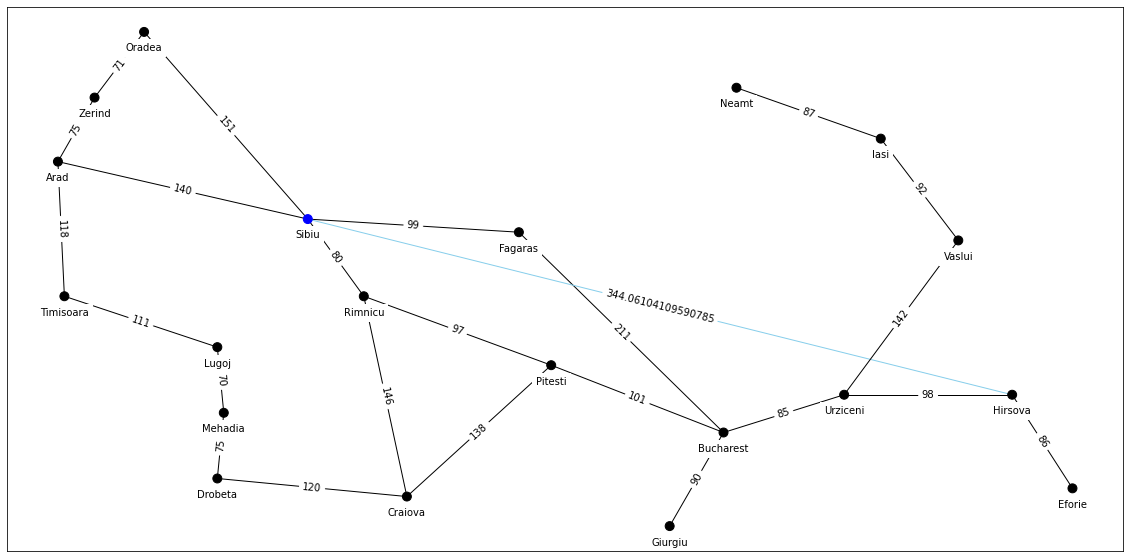

In [27]:
# Drücke wiederholt [Strg-Enter] um den Suchprozess schrittweise zu visualieren.
# Am Ende der Suchprozesses startet der Zähler automatisch wieder von vorne.
# Führe die vorherige Zelle aus, um die Suche zu unterbrechen und wieder von vorne zu starten. 
kostenfunktion = lambda knoten: luftlinie_routenplanung(navi, knoten)
print(f"Schritt {zaehler}:")
knoten_aktuell, farben, zaehler = bestensuche_visualisierung(navi, kostenfunktion, zaehler)
ort = knoten_aktuell.zustand
ziel = navi.zielzustand

# Hilfreiche Informationen über den aktuellen Stand der Suche
if knoten_aktuell:
    print(f"Stadt: {ort}  Bewertung: {kostenfunktion(knoten_aktuell)}")
# Füge die Luftlinie temporär als Kante ein
kanten_neu = navi.strassen.copy()
kanten_neu[ort] = navi.strassen[ort].copy()
kanten_neu[ort][ziel] = kostenfunktion(knoten_aktuell)
farben[(ort, ziel)] = "skyblue"  # passt so schöne zur Luftlinie ;-)
# Karte zeichnen
zeichne_karte(navi.staedte, kanten_neu, farben=farben)

#### Frage: ####
Vergleiche das Verhalten der *heuristischen* Suche beim Planen der Route von Sibiu nach Hirsova mit dem der *uniformen Kostensuche* beim selben Problem. Was fällt auf?

#### Deine Beobachtung: ####
[*Hier Antwort einsetzen*]

## Der A*-Algorithmus

Neben der heuristischen Einschätzung eines Knotens sollen auch die realen Pfadkosten dorthin, in die Bewertungsfunktion einbezogen werden. Wir definieren daher:

In [28]:
def a_stern_suche(problem, heuristik_funktion):
    def a_stern_kostenfunktion(knoten):
        return knoten.pfadkosten + heuristik_funktion(problem, knoten)
    return bestensuche(problem, a_stern_kostenfunktion)

In [29]:
a_stern_suche(navi, luftlinie_routenplanung)

['Rimnicu', 'Pitesti', 'Bucharest', 'Urziceni', 'Hirsova']

In [30]:
# Dieser Zähler wird in der nächsten Zelle verwendet und dort automatisch
# geändert.  Wenn du wieder bei 1 starten willst, führe einfach
# diese Zelle hier noch einmal aus.
zaehler = 1

Schritt 1:
Stadt: Sibiu  Bewertung: 344.06104109590785


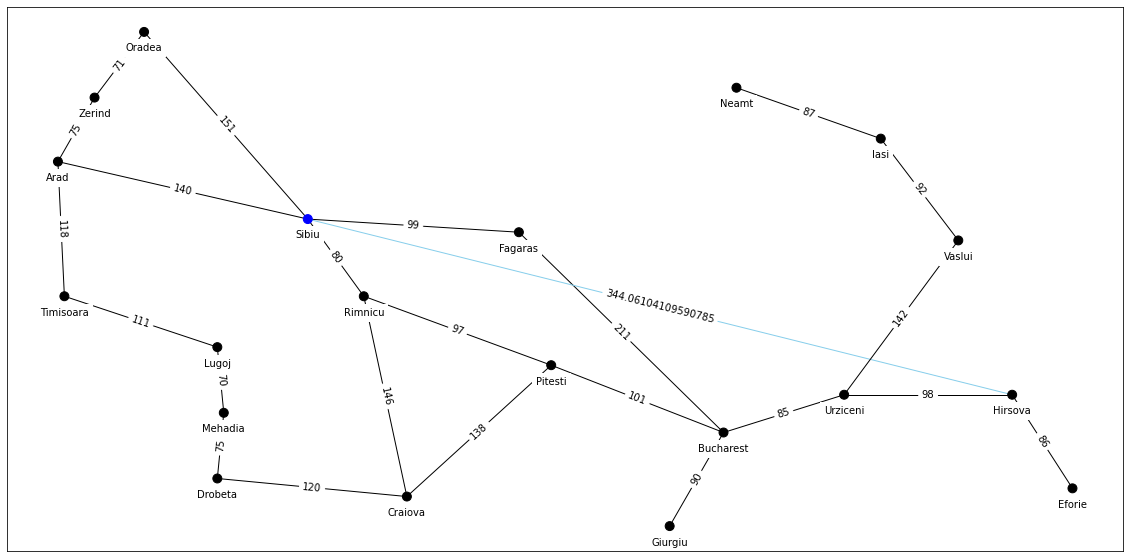

In [31]:
# Drücke wiederholt [Strg-Enter] um den Suchprozess schrittweise zu visualieren.
# Am Ende der Suchprozesses startet der Zähler automatisch wieder von vorne.
# Führe die vorherige Zelle aus, um die Suche zu unterbrechen und wieder von vorne zu starten. 
print(f"Schritt {zaehler}:")
kostenfunktion = lambda knoten: knoten.pfadkosten + luftlinie_routenplanung(navi, knoten)
knoten_aktuell, farben, zaehler = bestensuche_visualisierung(navi, kostenfunktion, zaehler)
ort = knoten_aktuell.zustand
ziel = navi.zielzustand

# Hilfreiche Informationen über den aktuellen Stand der Suche
if knoten_aktuell:
    print(f"Stadt: {ort}  Bewertung: {kostenfunktion(knoten_aktuell)}")
# Füge die Luftlinie temporär als Kante ein
kanten_neu = navi.strassen.copy()
kanten_neu[ort] = navi.strassen[ort].copy()
kanten_neu[ort][ziel] = kostenfunktion(knoten_aktuell)
farben[(ort, ziel)] = "skyblue"  # passt so schöne zur Luftlinie ;-)
# Karte zeichnen
zeichne_karte(navi.staedte, kanten_neu, farben=farben)

#### Frage:
Hervorragend! Die optimale Lösung wurden gefunden - und dafür nur ein Suchschritt mehr benötigt als vorher. 

Diesmal hat der Algorithmus Fagaras zwar untersucht, aber sofort wieder verworfen. Kannst du begründen, warum? 

**[Hier Antwort einsetzen]**

## Heuristische Suche beim anderen Suchproblemen
Eine Heuristik kann einen Suchprozess in die "richtige Richtung" steuern. Ist sie in einen Algorithmus wie A\* integriert, der die *echten* Kosten trotzdem berücksichtigt, ist es möglich den Suchprozess massiv zu beschleunigen und trotzdem garantiert *optimale* Lösungen zu finden.

Die heuristische Bewertungsfunktion schätzt die Kosten für den (noch unbekannten) Pfad vom aktuellen Suchknoten bis zum Ziel.  Aber nicht jede Heuristik ist *informativ*. Z.B. wird die *zufällige* Bewertung eines Zustands wohl kaum zu einer schnelleren Suche führen. 

Gleiches gilt für die Heuristik $h=0$, die für *jeden* Knoten einfach den Wert 0 zurückliefert. Was passiert wohl, wenn man den A\*-Algorithmus mit dieser Heuristik verwendet?

**[Hier Antwort einsetzen.]**

Ideal sind Heuristiken, die möglichst nahe an den tatsächlich Kosten für den restlichen Weg zu Ziel liegen, diese Kosten aber leicht *unterschätzen*.  

Kannst du intuitiv begründen, warum *unterschätzen* besser ist als *überschätzen*?

**[Hier Antwort einsetzen.]**

### Heuristiken für das Schiebepuzzle

In [32]:
leicht = "BC AEFDGH"
mittel = "ACFEBH DG"
schwer = "ABCF DGHE"
hart = 'CBHEADFG '

ziel  = 'ABCDEFGH '

**Aufgabe:** Überlege dir eine Heuristik für das Schiebepuzzle. Gesucht ist also eine Bewertungsfunktion, die für einen beliebigen Zustand eine Zahl berechnet, so dass Zustände "nah am Ziel" mit niedrigeren Zahlen bewertet werden als diejenigen, die "weit vom Ziel" entfernt sind.

In [33]:
def null_heuristik(puzzle, zielzustand  = 'ABCDEFGH '):
    return 0    # TODO: Diese uninformative Heuristik bitte verbessern!

In [34]:
def falsch_positionierte_steine(zustand, zielzustand='ABCDEFGH '):
    return sum(1 for a, b in zip(zustand, zielzustand) if a != b) - 1   # Leerzeichen nicht mitzählen

In [35]:
def manhattan_distanz(zustand, zielzustand='ABCDEFGH '):
    gesamt = 0
    for pos, stein in enumerate(zustand):
        if stein == ' ':
            continue
        y, x = divmod(pos, 3)
        zpos = zielzustand.index(stein)
        zy, zx = divmod(zpos, 3)
        gesamt += abs(x - zx) + abs(y - zy)
    return gesamt

In [36]:
start = 'CBD AFGEH'
fast_am_ziel = 'ABCDEFG H'

#heuristik_funktion = null_heuristik
#heuristik_funktion = falsch_positionierte_steine
heuristik_funktion = manhattan_distanz

print(heuristik_funktion(start))
print(heuristik_funktion(fast_am_ziel))  # soll viel besser (niedriger) bewertet werden als start

9
1


In [66]:
import schiebepuzzle    # Funktionen aus dem Notebook "Schiebepuzzle"

class Schiebepuzzle(Suchproblem):

    def moegliche_aktionen(self, zustand):
        return schiebepuzzle.moegliche_zuege(zustand)

    def fuehre_aktion_aus(self, zustand, aktion):
        return schiebepuzzle.verschiebe_pos(zustand, aktion)
    
    def aktionskosten(self, zustand, aktion, zustand_neu=None):
        return 1    # NEU: alle Aktionen haben einheitliche Kosten von 1

In [67]:
def teste_algorithmus(start, algorithmus, Problemklasse=Schiebepuzzle, zielzustand=ziel, kostenfunktion=None):
    problem = Problemklasse(start, ziel)
    loesung = algorithmus(problem, kostenfunktion)   # !!! hier wird die als Argument übergebene Funktion aufgerufen
    print(f"Die Lösung besteht aus {len(loesung)} Zügen: {loesung}")
    return loesung

In [68]:
def a_stern_kostenfunktion(heuristik_funktion):
    def _kostenfunktion(knoten):
        return knoten.pfadkosten + heuristik_funktion(problem, knoten)
    return _kostenfunktion

def a_stern_spezialisiert(heuristik_funktion):
    def _algorithmus(problem, kostenfunktion):
        return bestensuche(problem, a_stern_kostenfunktion(heuristik_funktion))

def a_stern_suche(problem, heuristik_funktion):
    def a_stern_kostenfunktion(knoten):
        return knoten.pfadkosten + heuristik_funktion(problem, knoten)
    return bestensuche(problem, a_stern_kostenfunktion)

def luftlinie_routenplanung(problem, knoten):
    koord_start = problem.staedte[knoten.zustand]    # weil die nichtlokale Variable problem "eingeschlossen" wird
    koord_ziel = problem.staedte[problem.zielzustand]
    return luftlinie(koord_start, koord_ziel)  

Probieren wir es zunächst mit der ersten Heuristik, bei der wir die Anzahl falsch positionierter Steine zählen:

In [69]:
%%time
print("Für das folgende Problem benötigte die verbesserte (!) Breitensuche mehr als 8 Minuten!")
loesung = teste_algorithmus(hart, bestensuche, kostenfunktion=lambda knoten: knoten.pfadkosten + falsch_positionierte_steine(knoten.zustand))

Für das folgende Problem benötigte die verbesserte (!) Breitensuche mehr als 8 Minuten!
Die Lösung besteht aus 26 Zügen: [7, 6, 3, 4, 5, 8, 7, 4, 1, 0, 3, 6, 7, 8, 5, 2, 1, 4, 7, 8, 5, 4, 3, 6, 7, 8]
Wall time: 4.63 s


Wow, statt mehrerer Minuten benötigen wir nur noch ein paar Sekunden für die Suche. 

Aber vielleicht ist die *Manhattan-Distanz* ja noch *informativer*, d.h. vielleicht hilft sie dem Suchalgorithmus noch besser, vielversprechende von weniger vielversprechenden Zuständen zu unterscheiden:

In [70]:
%%time
print("Für das folgende Problem benötigte die verbesserte (!) Breitensuche mehr als 8 Minuten!")
loesung = teste_algorithmus(hart, bestensuche, kostenfunktion=lambda knoten: knoten.pfadkosten + manhattan_distanz(knoten.zustand))

Für das folgende Problem benötigte die verbesserte (!) Breitensuche mehr als 8 Minuten!
Die Lösung besteht aus 26 Zügen: [7, 4, 1, 0, 3, 4, 5, 2, 1, 0, 3, 4, 7, 6, 3, 4, 7, 8, 5, 4, 1, 0, 3, 6, 7, 8]
Wall time: 239 ms


Das ist ja super: von 8 Minuten auf 130ms!!!

Aber es geht sogar noch schneller: Wenn wir in Kauf nehmen, eventuell nicht die *optimale* Lösung zu finden, können wir die "Greediness" des A\*-Algorithmus "stufenlos" variieren:

In [81]:
%%time
print("Für das folgende Problem benötigte die verbesserte (!) Breitensuche mehr als 8 Minuten!")
loesung = teste_algorithmus(hart, bestensuche, kostenfunktion=lambda knoten: knoten.pfadkosten + 3*manhattan_distanz(knoten.zustand))

Für das folgende Problem benötigte die verbesserte (!) Breitensuche mehr als 8 Minuten!
Die Lösung besteht aus 30 Zügen: [5, 2, 1, 4, 3, 6, 7, 8, 5, 4, 3, 0, 1, 2, 5, 4, 3, 0, 1, 4, 7, 8, 5, 2, 1, 0, 3, 4, 5, 8]
Wall time: 5.97 ms


Nur noch 2ms!!! (Allerdings für eine offensichtlich suboptimale Lösung.)